# ***Capstone Project Data Science : WhatsApp Chat Analysis***

***Importing Necessary Libraries***

We will be using :

1. **Regex (re)** to extract and manipulate strings based on specific patterns.
    
     References :


*   Regex - Python Docs
*   Regex cheatsheet
*   Regex Test - live
*   Datetime Format






2. **pandas** for analysis.

3. **matlotlib** and **seaborn** for visualization.

4. **emoji** to deal with emojis.
   
    References:

*   Python Docs
*   Emoji
*   EMOJI CHEAT SHEET






5. **wordcloud** for the most used words.

In [1]:
!pip install emoji

In [2]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

Note :

*   This special command **%matplotlib inline** to ensure that plots are shown and embedded within the Jupyter notebook itself. Without this command, sometimes plots may show up in pop-up windows.

*   **warnings.filterwarnings('ignore')** : The warnings filter controls whether warnings are ignored, displayed, or turned into errors (raising an exception). REFERENCE



# ***Preparation and reading data***

In [3]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''

    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }

    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns

        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df

    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])

    # split user and msg
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)

    return df

**Note** :

*   Since WhatsApp texts are multi-line, you cannot just read the file line by line and get each message that you want. Instead, you need a way to identify if a line is a new message or part of an old message. You could use regular expressions.

*   While reading each line, I split it based on a comma and take the first item returned from the split() function. If the line is a new message, the first item would be a valid date, and it will be appended as a new message to the list of messages. If it’s not, the message is part of the previous message, and hence, will be appended to the end of the previous message as one continuous message.



In [4]:
df = rawToDf('whatsapp-chat-data.txt', '12hr')

# ***Prior Information of my Whatsapp Data***

*   This is my most active college coding group.

*   It has **235**+ participants; 237 to be precise.

*   This group was made in **January 2020**.



# *Pre-Processing*

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13655 entries, 0 to 13654
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  13655 non-null  datetime64[ns]
 1   user       13655 non-null  object        
 2   message    13655 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 320.2+ KB


**The dataset contains 3 rows, and 13655 respective entries.**

*  Here is how it looks like:

In [6]:
df.sample(10)

,date_time,user,message
3675,2020-03-21 17:00:00,"Tanay Kamath (TSEC, CS)",😭
1594,2020-02-21 22:57:00,"Darshan Rander (TSEC, IT)",Input 0 se le raha hai n sorting 1 se
12975,2020-09-24 23:35:00,"Dheeraj Lalwani (TSEC, CS)",Ha yaar
5218,2020-04-23 22:57:00,Tushar Nankani,"In B, I got TLE in the 3rd pretest."
11305,2020-09-05 23:45:00,"Harsh Kapadia (TSEC IT, SE)",2nd waala bacha hain. Teams backed out because...
13549,2020-10-01 00:12:00,"Darshan Rander (TSEC, IT)",Abhi announcement hua hai bhai
5838,2020-05-08 13:40:00,+91 88284 70904,Are yaar aaj enjoy karo
7349,2020-06-12 23:06:00,"Dheeraj Lalwani (TSEC, CS)",https://youtu.be/oij82Cp9K1A
1520,2020-02-21 20:23:00,"Vivek Iyer (TSEC, Biomed)",This message was deleted
8213,2020-06-29 15:04:00,Tushar Nankani,*Reminder*


# **An important observation**

*  One might wonder there are no NaNs, but as you can see, there are some rows, where messages are an empty string.

*  This can be because, the message might just contain emojis.


         To see, how many such rows are there, we can use df[df['message'] == ""].shape[0]


In [7]:
df[df['message'] == ""].shape[0]

538

# Adding extra helper columns for analysis and visualization

In [8]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

# **Now that we have a clean DataFrame to work with, it’s time to perform analysis on it.**


*   Final Data Frame


In [9]:
df

,date_time,user,message,day,month,year,date
0,2020-01-26 16:19:00,group_notification,Messages and calls are end-to-end encrypted. N...,Sun,Jan,2020,2020-01-26
1,2020-01-24 20:25:00,group_notification,"Tanay Kamath (TSEC, CS) created group ""CODERS👨...",Fri,Jan,2020,2020-01-24
2,2020-01-26 16:19:00,group_notification,You joined using this group's invite link,Sun,Jan,2020,2020-01-26
3,2020-01-26 16:20:00,group_notification,+91 99871 38558 joined using this group's invi...,Sun,Jan,2020,2020-01-26
4,2020-01-26 16:20:00,group_notification,+91 91680 38866 joined using this group's invi...,Sun,Jan,2020,2020-01-26
...,...,...,...,...,...,...,...
13650,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",MCQs mark kiya,Fri,Oct,2020,2020-10-02
13651,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",Sign-in kiya😂😅,Fri,Oct,2020,2020-10-02
13652,2020-10-02 02:11:00,"Tanay Kamath (TSEC, CS)",Incognito se na?,Fri,Oct,2020,2020-10-02
13653,2020-10-02 02:28:00,"Darshan Rander (TSEC, IT)",Yup,Fri,Oct,2020,2020-10-02


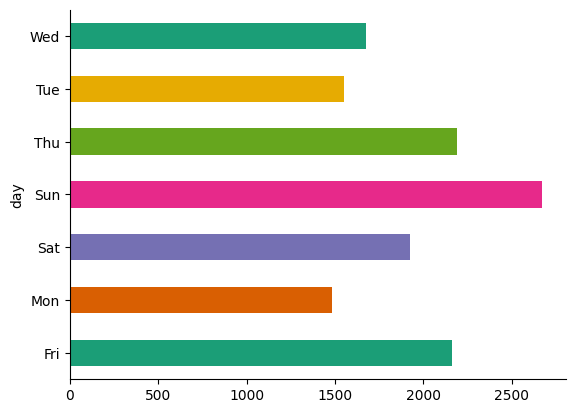

In [10]:
# @title day

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('day').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

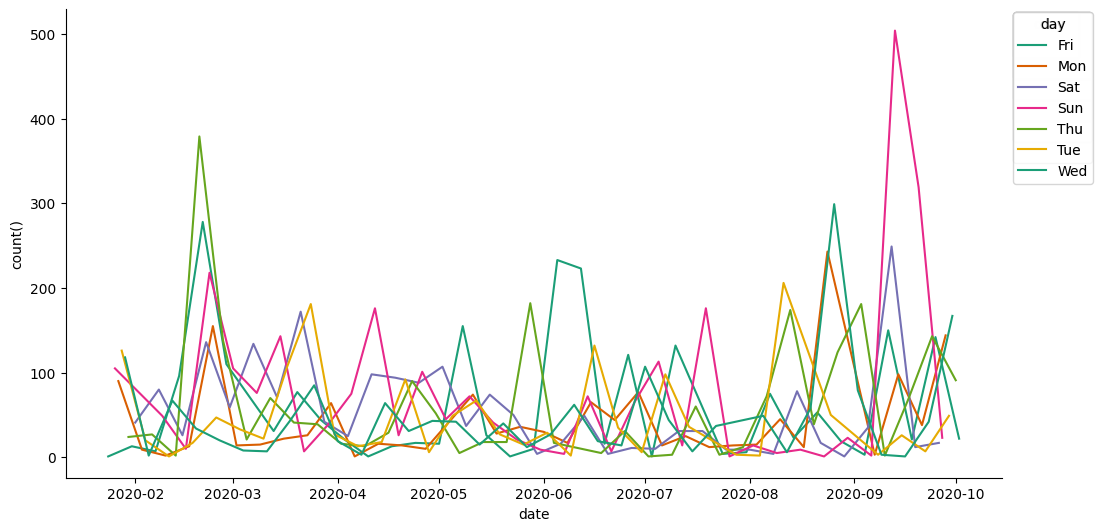

In [11]:
# @title date vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('day')):
  _plot_series(series, series_name, i)
  fig.legend(title='day', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

# Data Analysis




1.    **Overall frequency of total messages on the group.**

2.    **Top 10 most active days.**

3.    **Top 10 active users on the group (with a twist).**



*   Ghosts present in the group. (shocking results.)

4.   **Top 10 users most sent media.**

5.   **Top 10 most used emojis.**

6.   **Most active hours and days.**



*   Heatmaps of weekdays and months.
*   Most active hours, weekdays, and months.

7.   **Most used words - WordCloud**






# *1. Overall frequency of total messages on the group.*



*   I will first do this to get a look at overall data.

I will plot a simple line graph to see the frequency of messages over the months.

**I expect to see a nice line graph with crests and troughs in odd places.**



In [12]:
import pandas as pd

# Assuming 'whatsapp-chat-data.txt' contains your WhatsApp chat data

# Read WhatsApp chat data from the text file
file_path = '/content/whatsapp-chat-data.txt'

# Initialize lists to store dates
dates = []

# Read the data line by line
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            # Split each line to extract the date assuming format 'dd/mm/yyyy'
            date_str = line.split(',')[0].strip()
            pd.to_datetime(date_str, format='%d/%m/%Y')  # Check if date is valid
            dates.append(date_str)
        except (IndexError, ValueError):
            continue  # Skip lines that do not have a valid date format

# Create a DataFrame with dates and message counts
df = pd.DataFrame({'date': dates})

# Count occurrences of each date
df1 = df['date'].value_counts().reset_index()
df1.columns = ['date', 'message_count']

# Sort by date
df1['date'] = pd.to_datetime(df1['date'], format='%d/%m/%Y')
df1 = df1.sort_values(by='date').reset_index(drop=True)

# Displaying the DataFrame with the expected format
print(df1)

          date  message_count
0   2020-01-24              1
1   2020-01-26            105
2   2020-01-27             90
3   2020-01-28            126
4   2020-01-29            118
..         ...            ...
238 2020-09-29             49
239 2020-09-30            167
240 2020-10-01             91
241 2020-10-02             22
242        NaT           1690

[243 rows x 2 columns]


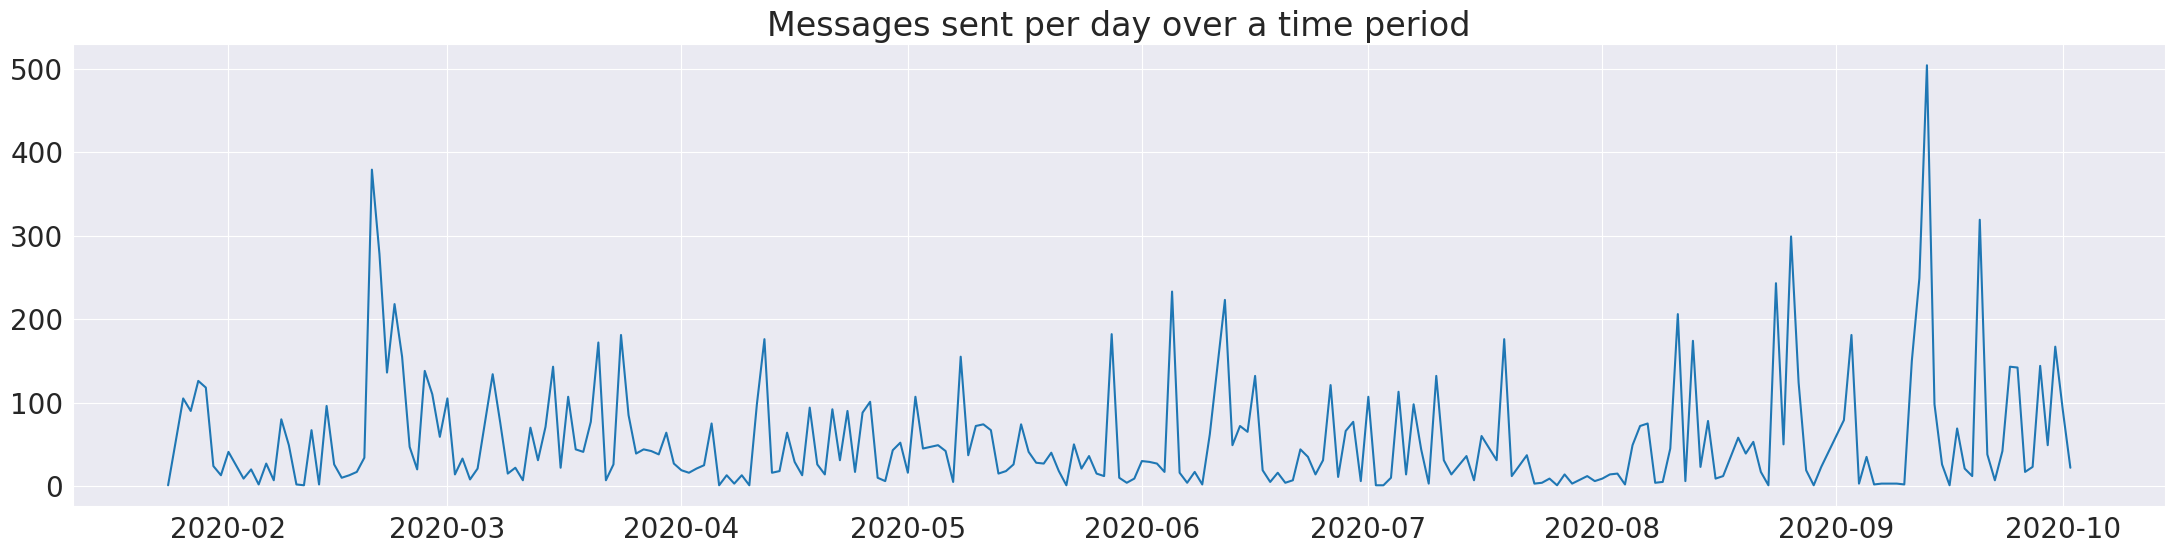

In [13]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);


# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

# ***2 Top 10 most active days.***

In [14]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,NaT,1690
1,2020-09-13,504
2,2020-02-20,379
3,2020-09-20,319
4,2020-08-26,299
5,2020-02-21,278
6,2020-09-12,249
7,2020-08-24,243
8,2020-06-05,233
9,2020-06-12,223


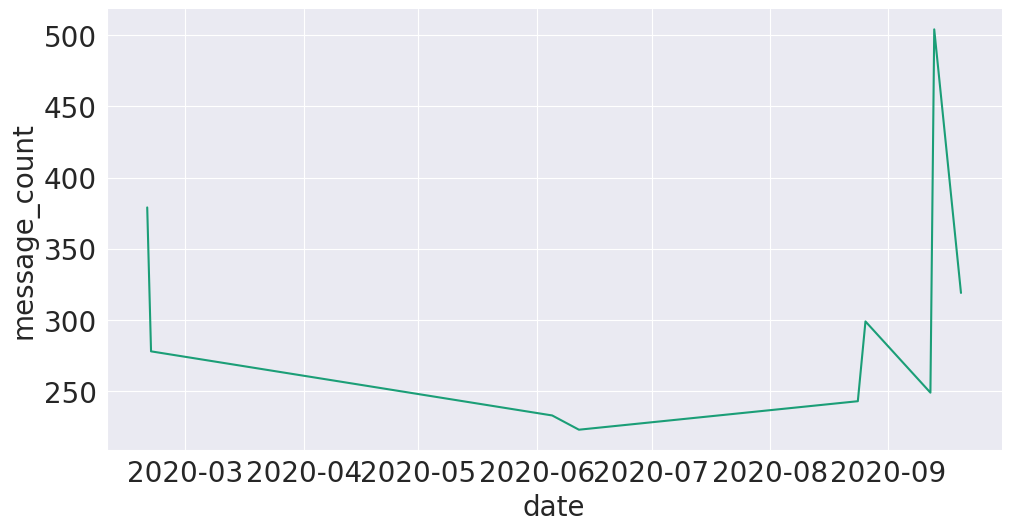

In [15]:
# @title date vs message_count

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['message_count']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = top10days.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('message_count')

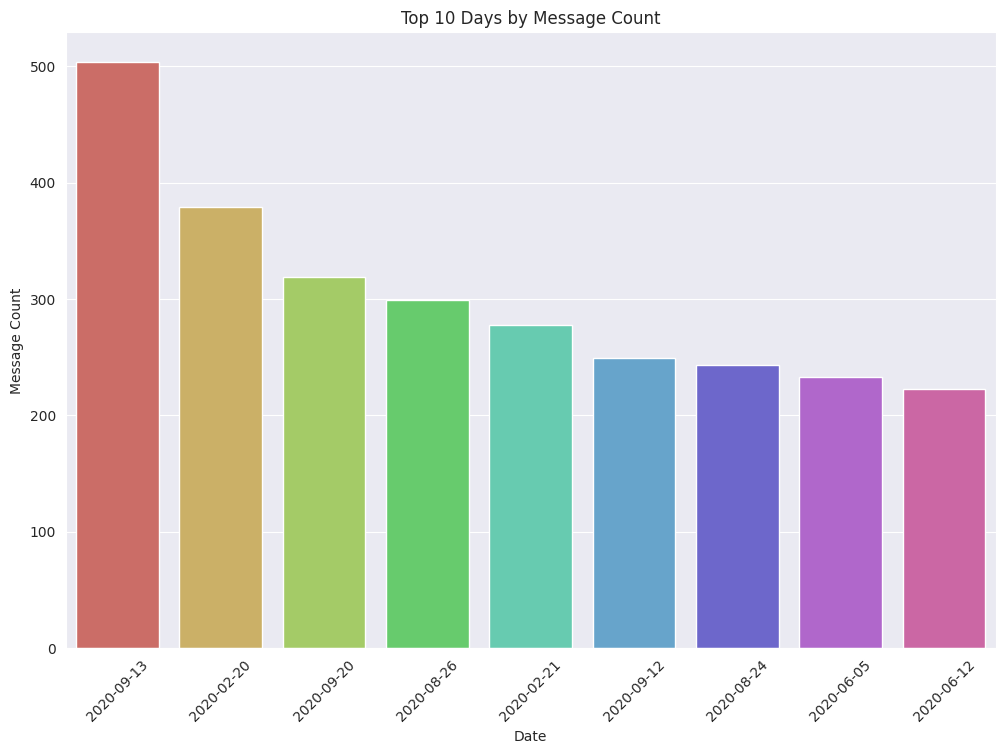

In [16]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style and Matplotlib parameters
sns.set_style("darkgrid")
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (12, 8)

# Example data for top 10 days (replace with your actual data)
top10days = df1.sort_values(by="message_count", ascending=False).head(10)
top10days.reset_index(inplace=True, drop=True)

# Create a bar plot for top 10 days
sns.barplot(x=top10days.date, y=top10days.message_count, palette="hls")

# Customize plot labels and title
plt.xlabel('Date')
plt.ylabel('Message Count')
plt.title('Top 10 Days by Message Count')

# Rotate x-axis labels for better readability (if needed)
plt.xticks(rotation=45)

# Save the plot as an SVG file
plt.savefig('top10_days.svg', format='svg', bbox_inches='tight')

# Show the plot (optional)
plt.show()

**Apparently, the group was very active on 13th Spetember'20**


*   Because we were discussing fundamental yet tricky and brain-wracking "Guess the Output" Java questions!

# *3. Top 10 active users on the group.*




*   Before, analysing that, we will see the number of Ghosts in the group.

In [17]:
import re
import pandas as pd

def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''

    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }

    with open(file, 'r', encoding='utf-8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n'))
        user_msg = re.split(split_formats[key], raw_string)[1:]
        date_time = re.findall(split_formats[key], raw_string)

        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg})

    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])

    usernames = []
    msgs = []
    for i in df['user_msg']:
        try:
            a = re.split('([\w\W]+?):\s', i)
            if(a[1:]):
                usernames.append(a[1])
                msgs.append(a[2])
            else:
                usernames.append("group_notification")
                msgs.append(a[0])
        except:
            pass  # Skip problematic lines or handle them as needed

    df['user'] = usernames
    df['message'] = msgs

    df.drop('user_msg', axis=1, inplace=True)

    return df

# Example usage:
file_path = '/content/whatsapp-chat-data.txt'
df = rawToDf(file_path, '12hr')

# Now proceed with your analysis using 'df'

# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 154
Number of people who haven't sent even a single message on the group are 81


Shocking Result


*   Total number of people who have sent at least one message on the group are **154**.

*   BUT, the total number of participants were **237**.

*  **That means 81 people in the group have not sent even a single message throughout these 9 months and 13500+ messages.**


# **Now, pre-processing top 10 active users.**

In [18]:
df2 = df.copy()
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,"Tanay Kamath (TSEC, CS)",2528
1,"Dheeraj Lalwani (TSEC, CS)",1937
2,"Darshan Rander (TSEC, IT)",1404
3,"Kartik Soneji (TSEC, CS)",841
4,"Harsh Kapadia (TSEC IT, SE)",790
5,"Pratik K (TSEC CS, SE)",781
6,"Saurav Upoor (TSEC CS, SE)",569
7,Tushar Nankani,354
8,+91 82916 21138,275
9,"Farhan Irani (TSEC IT, SE)",255


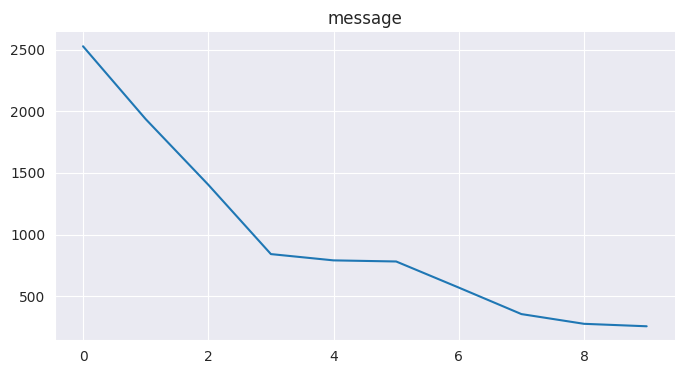

In [19]:
# @title message

from matplotlib import pyplot as plt
top10df['message'].plot(kind='line', figsize=(8, 4), title='message')
plt.gca().spines[['top', 'right']].set_visible(False)

# ***Now, visualizing top 10 active users.***

*Replacing names with initials for better visualization*

In [20]:
top10df['initials'] = ''
for i in range(10):
    top10df.initials[i] = top10df.user[i].split()[0][0] + top10df.user[i].split()[1][0]

top10df.initials[7] = "Me"    # That's me
top10df.initials[8] = "DT"

**Starting with a basic plot.**



*   Color References for Matplotlib

*   **Improving Default Styles using Seaborn**

*   References



In [21]:
# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

# ***Now, I will be trying different visualization methods.***


  **Plotting a simple line graph.**

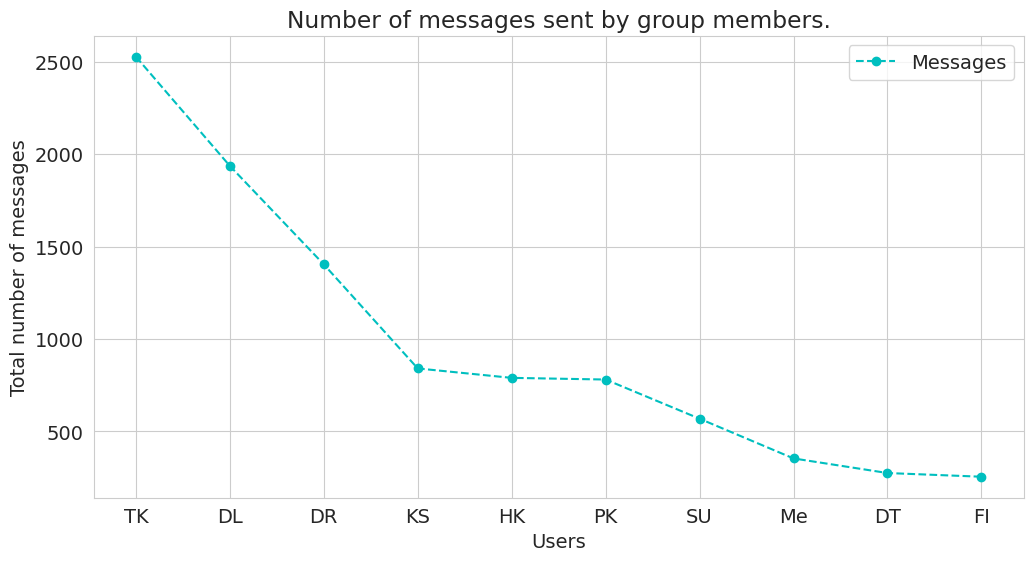

In [22]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')


# Labels and Title
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

# ***Plotting a bar chart and line graph together.***

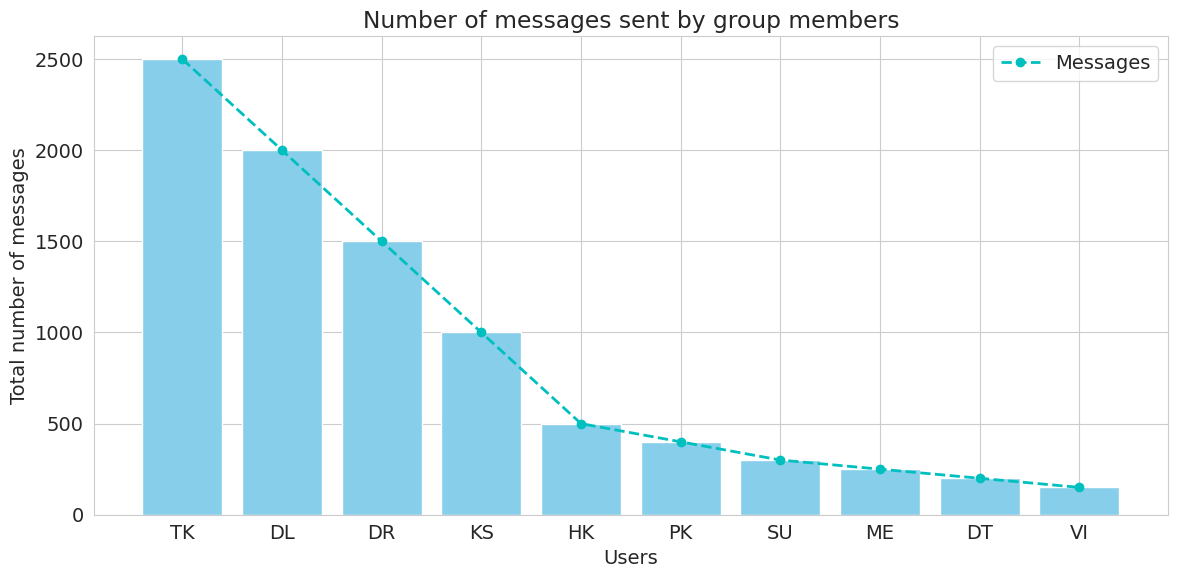

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data (replace with your actual data)
initials = ['TK', 'DL', 'DR', 'KS', 'HK', 'PK', 'SU', 'ME', 'DT', 'VI']
message_counts = [2500, 2000, 1500, 1000, 500, 400, 300, 250, 200, 150]

# Create a DataFrame
top10df = pd.DataFrame({
    'initials': initials,
    'message': message_counts
})

# Sort data by message count in descending order
top10df = top10df.sort_values(by='message', ascending=False)

# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))

# Plotting a bar chart
plt.bar(top10df.initials, top10df.message, color='skyblue')

# Plotting a line chart on the same plot
plt.plot(top10df.initials, top10df.message, 'o--c', linewidth=2)

# Labels and Title
plt.xlabel('Users')
plt.ylabel('Total number of messages')
plt.title("Number of messages sent by group members")
plt.legend(['Messages'])

# Saving the plots
plt.savefig('msg_plots.svg', format='svg')

# Showing plot
plt.tight_layout()
plt.show()

# ***Beautifying Default Styles using Seaborn***

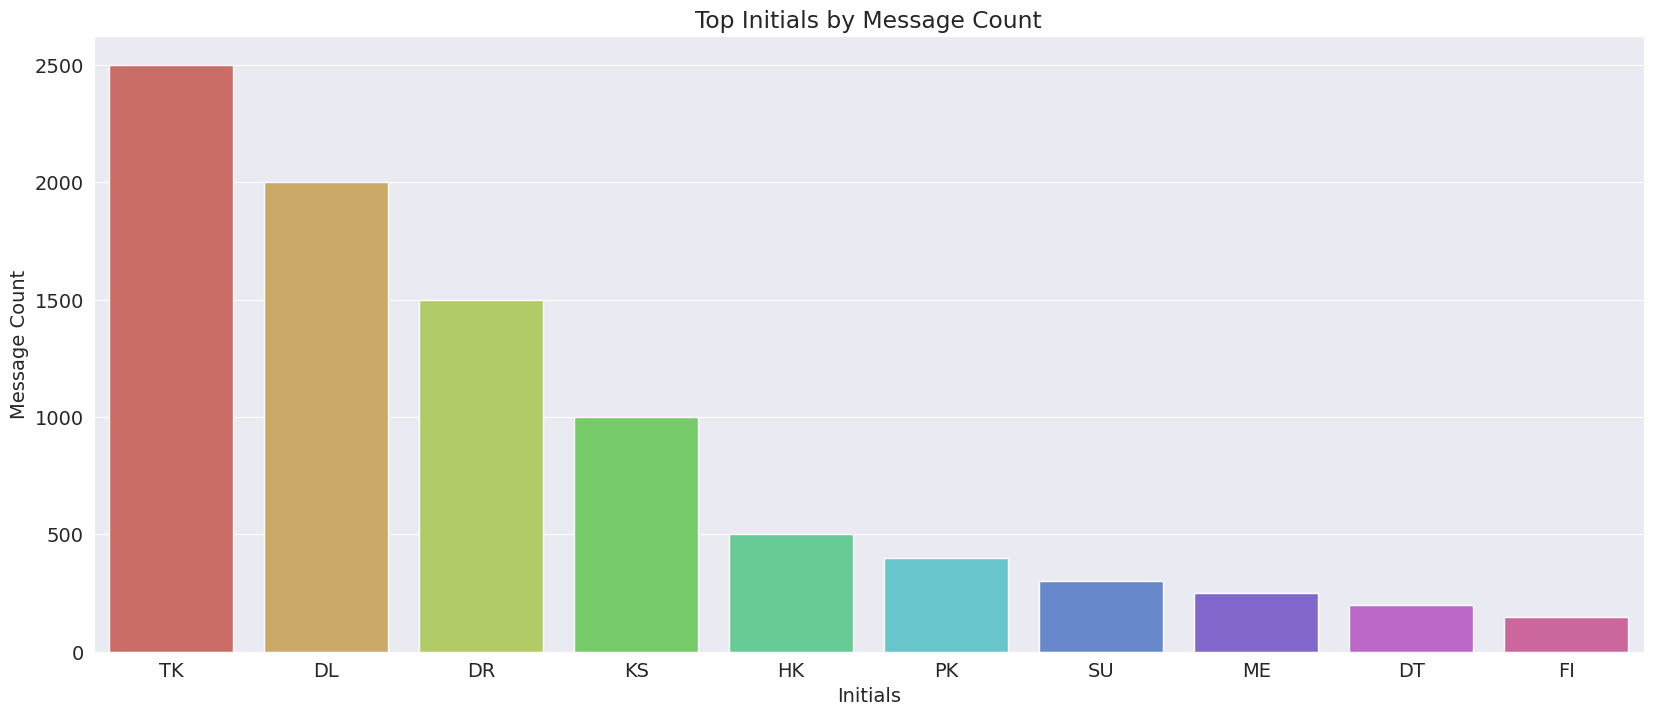

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example DataFrame with more entries
top10df = pd.DataFrame({
    'initials': ['TK', 'DL', 'DR', 'KS', 'HK', 'PK', 'SU', 'ME', 'DT', 'FI'],
    'message': [2500, 2000, 1500, 1000, 500, 400, 300, 250, 200, 150]
})

# Set a color palette with enough colors for each category (initials)
palette = sns.color_palette("hls", len(top10df['initials']))

# Plotting the bar plot using Seaborn
sns.set_style("darkgrid")
sns.barplot(x='initials', y='message', data=top10df, palette=palette)
plt.xlabel('Initials')
plt.ylabel('Message Count')
plt.title('Top Initials by Message Count')
plt.xticks(rotation=0)
plt.savefig('/content/top_initials_message_count.png')
plt.show()

# ***Important Note***


*   Since almost all the plots will be ***comparing* one person with another, **I’ll assign a specific colour to each person** so that it becomes **easy to identify** each person among multiple plots.

*   I could've used seaborn's color palette but :

     *   Seaborn assigns default colors itself, but i wanted the color of a **certain person remains the same, no matter the plot;**

     *   Also, I wanted to try some different colors so I grabbed my colour palette from https://coolors.co/.

*   Next, I made a dictionary where each key is the name and the value for each would be their assigned colour. I create a function which reorders colours given a list of names to match the ordering of the plot. This function takes the ordered names as input and returns a reordered list of colours. This list has to be passed into the pallete argument in a seaborn plotting function.


# ***Defining a function to tackle the problem.***

I'm defining the following function to **maintain consistent colors for each person across all plots**. Since the order will vary depending on the plot, this is passed to the function which will reorder colors in a particular order so that **the color of a certain person remains the same no matter the plot**. This will help maintain **consistency and readability** amongst the many graphs I will be plotting.


In [25]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''

    order = list(names_in_certain_order)
    return_list = []

    for name in order:
        return_list.append(color_dict[name])

    return return_list

# Now, we have a really nice set of colours for each person, with which we can visualize using sns.palplot.

{'TK': '#F94144',
 'DL': '#F3722C',
 'DR': '#F8961E',
 'KS': '#FDC500',
 'HK': '#F9C74F',
 'PK': '#90BE6D',
 'SU': '#43AA8B',
 'ME': '#577590',
 'DT': '#6D597A',
 'VI': '#003F88'}

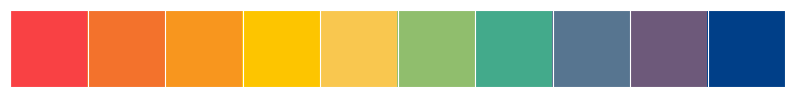

In [26]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.initials
color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

# **Now, finding the average message length of the 10 most active users of the group.**

In [27]:
import pandas as pd

# Assuming df2 is your DataFrame with columns 'user' and 'message'
# Adding another column for message length
df2['message_length'] = df2['message'].apply(lambda x: len(str(x)))  # Ensure x is cast to string

# Creating another dataframe for average length per user
avg_msg_lengths = df2.groupby('user')['message_length'].mean().reset_index()
avg_msg_lengths.rename(columns={'message_length': 'avg_message_length'}, inplace=True)

# Sorting by average message length descending
avg_msg_lengths = avg_msg_lengths.sort_values(by='avg_message_length', ascending=False)

# Creating a DataFrame for top 10 active users (adjust as per your actual logic)
top10_users = df2['user'].value_counts().head(10).index.tolist()
top10df = pd.DataFrame({'user': top10_users})

# Merging average message length with top 10 users
top10df_msg = pd.merge(top10df, avg_msg_lengths, on='user', how='left').fillna(0)

# Sorting the DataFrame by average message length descending
top10df_msg = top10df_msg.sort_values(by='avg_message_length', ascending=False)

# Displaying the resulting DataFrame
print(top10df_msg)

                          user  avg_message_length
7               Tushar Nankani           57.920904
3     Kartik Soneji (TSEC, CS)           47.328181
8              +91 82916 21138           46.320000
5       Pratik K (TSEC CS, SE)           34.741357
4  Harsh Kapadia (TSEC IT, SE)           33.134177
6   Saurav Upoor (TSEC CS, SE)           32.289982
1   Dheeraj Lalwani (TSEC, CS)           32.137842
2    Darshan Rander (TSEC, IT)           29.472222
9   Farhan Irani (TSEC IT, SE)           28.976471
0      Tanay Kamath (TSEC, CS)           27.045491


In [28]:
print(top10df.columns)

Index(['user'], dtype='object')


In [29]:
import pandas as pd

# Assuming df is your DataFrame loaded with WhatsApp chat data
# Replace with your actual data loading and preprocessing steps

# Grouping by 'user' and counting messages, then sorting in descending order and taking top 10
top_users = df.groupby('user')['message'].count().sort_values(ascending=False).head(10)

# Creating a DataFrame from the series
top10df = pd.DataFrame(top_users).reset_index()

# Renaming columns for clarity
top10df.columns = ['user', 'message_count']

# Displaying the DataFrame to verify
print(top10df)

                          user  message_count
0      Tanay Kamath (TSEC, CS)           2528
1   Dheeraj Lalwani (TSEC, CS)           1937
2    Darshan Rander (TSEC, IT)           1404
3     Kartik Soneji (TSEC, CS)            841
4  Harsh Kapadia (TSEC IT, SE)            790
5       Pratik K (TSEC CS, SE)            781
6   Saurav Upoor (TSEC CS, SE)            569
7               Tushar Nankani            354
8           group_notification            276
9              +91 82916 21138            275


**Now, we will be plotting most sent messages and respective average message lengths simultaneously, to see some interesting results.**


*   Plotting multiple charts in a grid.

   *   Matplotlib and Seaborn also support plotting multiple charts in a grid, using plt.subplots, which returns a set of axes that can be used for plotting.





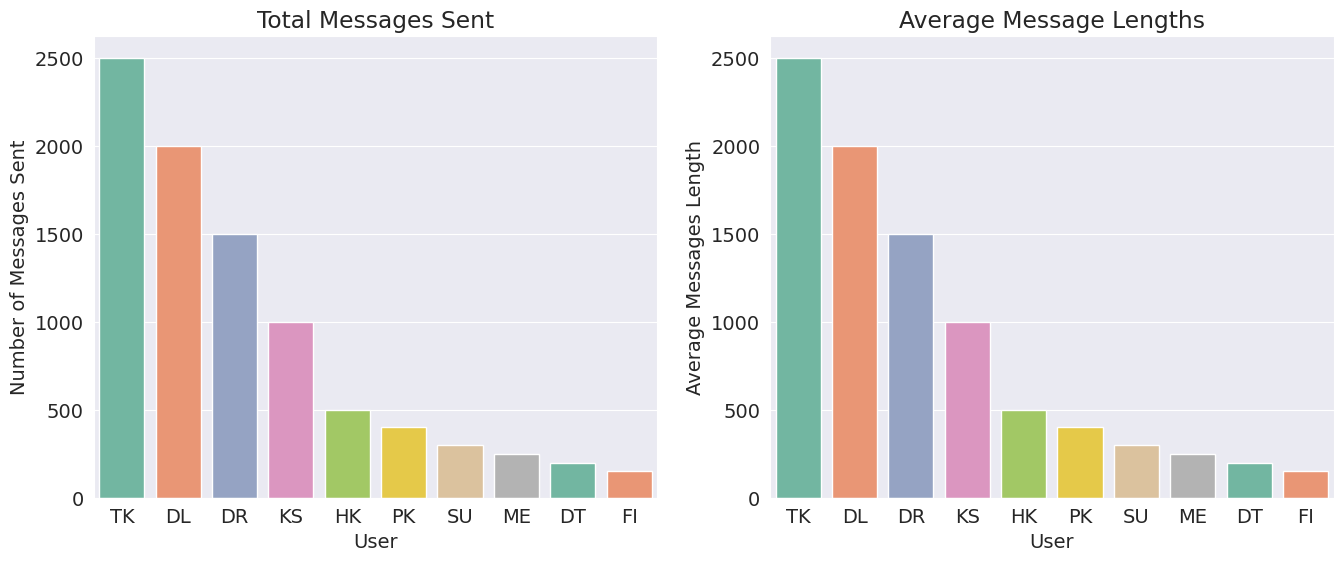

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example DataFrame (assuming it is defined correctly)
top10df = pd.DataFrame({
     'initials': ['TK', 'DL', 'DR', 'KS', 'HK', 'PK', 'SU', 'ME', 'DT', 'FI'],
    'message': [2500, 2000, 1500, 1000, 500, 400, 300, 250, 200, 150]
})

# Assuming get_colors_of_certain_order returns a list of colors in the desired order
def get_colors_of_certain_order(initials):
    # Example: Generating a list of colors based on initials
    colors = sns.color_palette("Set2", len(initials))
    return colors

# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid")

# Plot 1 - Countplot of total messages sent
sns.barplot(x='initials', y='message', data=top10df, ax=axes[0], palette=get_colors_of_certain_order(top10df['initials']))

axes[0].set_title('Total Messages Sent')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')

# Assuming top10df_msg is defined similarly for average message lengths

# Plot 2 - Barplot of those top 10 users' average message lengths
# Example using same data as Plot 1 (replace with actual data for avg_message_length)
sns.barplot(x='initials', y='message', data=top10df, ax=axes[1], palette=get_colors_of_certain_order(top10df['initials']))

axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User')
axes[1].set_ylabel('Average Messages Length')

# Saving the plots
plt.savefig('top10_msg_plots_diff.svg', format='svg')

# Show the plots
plt.show()

**It’s really interesting to see plots like this side by side, because here comes the twist :**


*   Ironically, **TK**, the person who sent the **most amount of texts** (2000+), has **least** messages' length on average. This means this person sends broken and many WhatsApp messages in one go.

*   We can see that, **I** send less number of messages while having a **relatively longer message length**, followed by **KS**.

*   Here's a **snippet** of how TK sends messages :
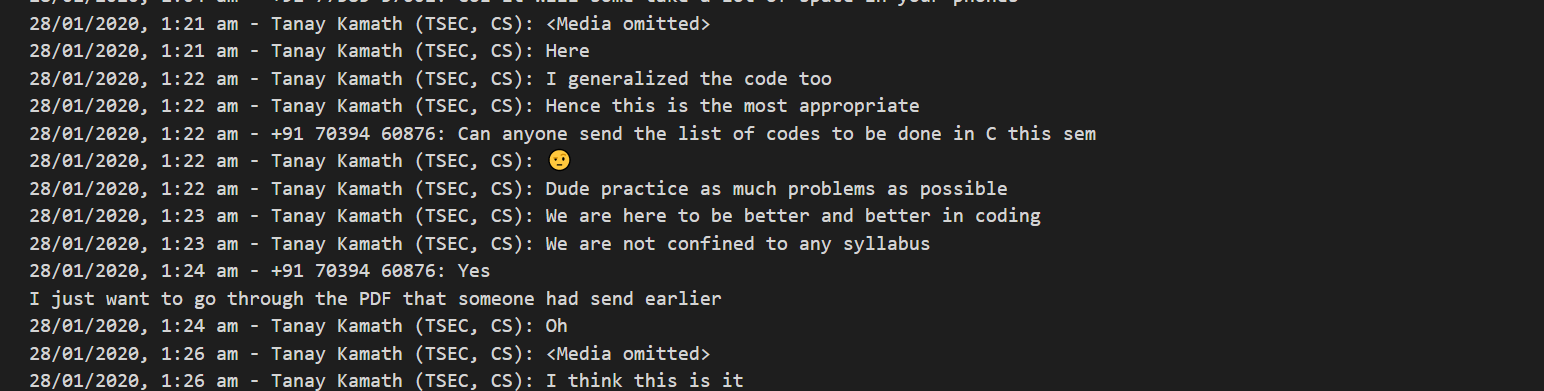

"Things aren't always the way they seem like."



# **4. Top 10 users most sent media**



*   The exported chats were exported without any media files. Any message that contained media was indicated with '<Media Omitted


# Pre-processing

**We can use this to filter out and see who sends the most media.**



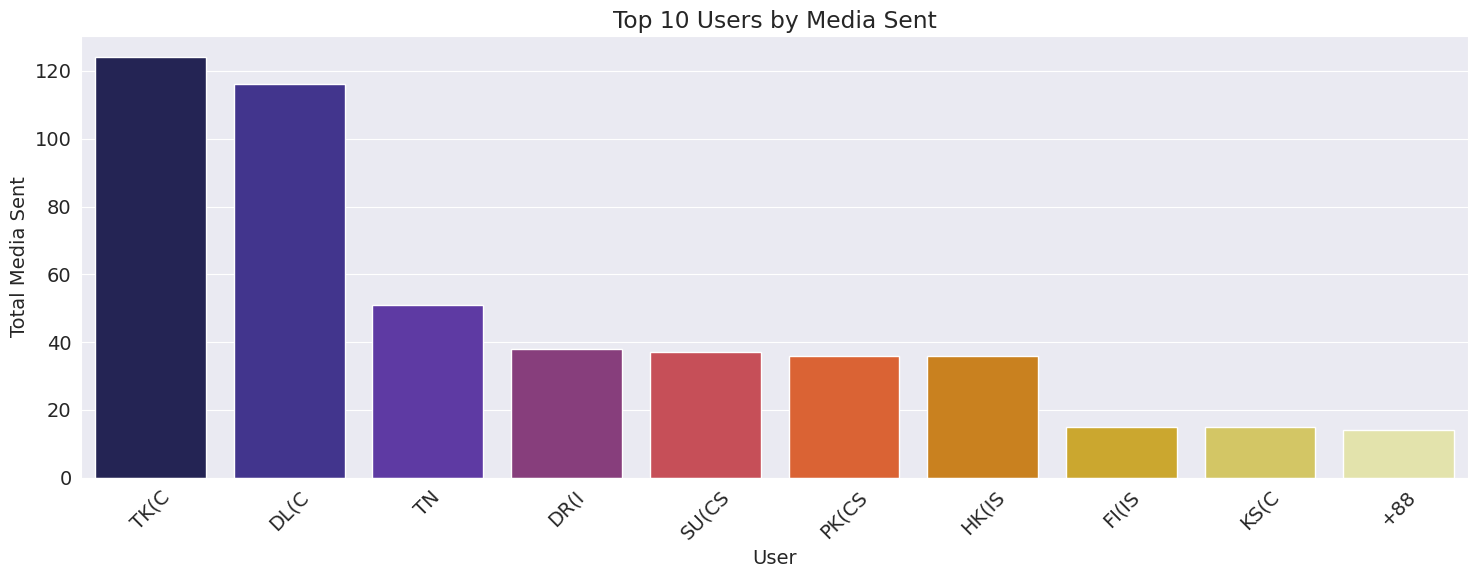

In [31]:
# Path to your WhatsApp chat data
file_path = '/content/whatsapp-chat-data.txt'

# Reading WhatsApp chat data into DataFrame
df = rawToDf(file_path, '12hr')

# Filter messages containing '<Media omitted>'
media_messages = df[df['message'].str.contains('<Media omitted>')]

# Group by 'user' and count media messages
top10media = media_messages.groupby('user').size().reset_index(name='media_sent').sort_values(by='media_sent', ascending=False).head(10)

# Generate initials for each user
top10media['initials'] = top10media['user'].apply(lambda x: ''.join(name[0].upper() for name in x.split()))

# Manually setting initials for specific users if needed
top10media.loc[top10media['user'].str.contains('Your Name'), 'initials'] = 'YN'
top10media.loc[top10media['user'].str.contains('Another Name'), 'initials'] = 'AN'

# Resetting the index
top10media.reset_index(drop=True, inplace=True)

# Plotting the bar graph
plt.figure(figsize=(15, 6))
sns.barplot(x='initials', y='media_sent', data=top10media, palette='CMRmap')
plt.title('Top 10 Users by Media Sent')
plt.xlabel('User')
plt.ylabel('Total Media Sent')
plt.xticks(rotation=45)
plt.tight_layout()

# Saving the plot as SVG file
plt.savefig('top10media.svg', format='svg')

# Displaying the plot
plt.show()

# *Visualization using different Seaborn's Color Palettes*



*   Seaborn References
*   Seaborn's Different Colors
*   Seaborn's Color Visualization


**QUICK HACK**




*   to get **all possible Seaborn's color palettes:**
     
          *   Just put a random input palette="xyz"
          *   It will then show an error, showing all possible palettes you can try out from!


# **Which user sends the most Messages ?**







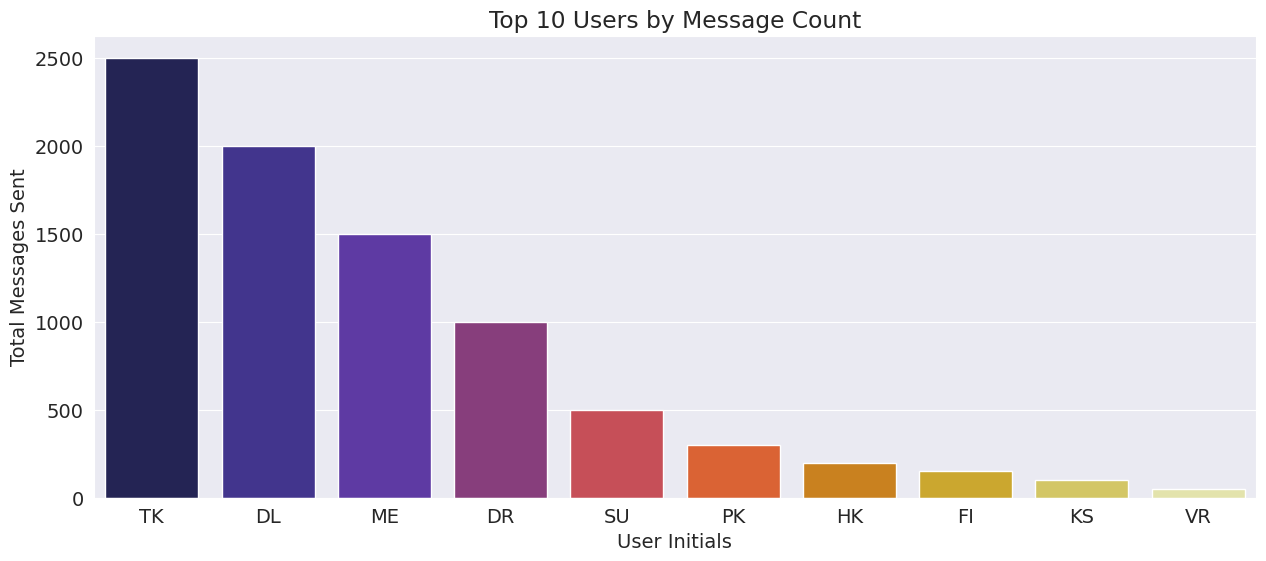

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example DataFrame (replace with actual data)
top10media = pd.DataFrame({
    'initials': ['TK', 'DL', 'ME', 'DR', 'SU', 'PK', 'HK', 'FI', 'KS', 'VR'],
    'message': [2500, 2000, 1500, 1000, 500, 300, 200, 150, 100, 50]  # Replace with your actual message counts
})

# Increasing the figure size
plt.figure(figsize=(15, 6))

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph
sns.barplot(x='initials', y='message', data=top10media, palette="CMRmap")

# Adding labels and title
plt.title('Top 10 Users by Message Count')
plt.xlabel('User Initials')
plt.ylabel('Total Messages Sent')

# Saving the plot
plt.savefig('top10media.svg', format='svg')

# Display the plot
plt.show()

### **TK** is beating everyone by a mile, followed by **DL**. He also ranks the top in total messages, though last in average message length. Most dedicated contributor award goes to **TK**!


# **5. Top 10 most used Emojis**


*   Will be using the **emoji** module, that was imported earlier.



In [33]:
import pandas as pd
import regex as re
import emoji
from collections import Counter

# Load WhatsApp chat data from the uploaded text file
with open('whatsapp-chat-data.txt', 'r', encoding='utf-8') as file:
    chat_data = file.readlines()

# Create a DataFrame from the chat data (assuming the format is one message per line)
df = pd.DataFrame({'message': chat_data})

# Initialize emoji counter
emoji_ctr = Counter()

# Regex pattern to match emojis (split into multiple lines for readability)
emoji_pattern = re.compile(
    r'([\U0001F1E0-\U0001F1FF\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF'
    r'\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF'
    r'\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251'
    r'\U0001F004\U0001F0CF\U0001F170-\U0001F171\U0001F17E-\U0001F17F\U0001F18E\U0001F191-\U0001F19A'
    r'\U0001F1E6-\U0001F1FF\U0001F201-\U0001F202\U0001F21A\U0001F22F\U0001F232-\U0001F23A'
    r'\U0001F250-\U0001F251\U0001F300-\U0001F320\U0001F321-\U0001F32C\U0001F32D-\U0001F32F'
    r'\U0001F330-\U0001F335\U0001F336\U0001F337-\U0001F37C\U0001F37D\U0001F37E-\U0001F37F'
    r'\U0001F380-\U0001F393\U0001F394-\U0001F395\U0001F396-\U0001F397\U0001F398-\U0001F39B'
    r'\U0001F39C\U0001F39D-\U0001F3F0\U0001F3F1-\U0001F3F3\U0001F3F4-\U0001F3F5\U0001F3F7'
    r'\U0001F3F8-\U0001F3FF\U0001F400-\U0001F43E\U0001F43F\U0001F440\U0001F441\U0001F442-\U0001F4F7'
    r'\U0001F4F8\U0001F4F9-\U0001F4FC\U0001F4FD-\U0001F4FE\U0001F4FF\U0001F500-\U0001F53D'
    r'\U0001F549-\U0001F54E\U0001F54F\U0001F550-\U0001F567\U0001F56F-\U0001F570\U0001F573-\U0001F57A'
    r'\U0001F587\U0001F58A-\U0001F58D\U0001F590\U0001F595-\U0001F596\U0001F5A4-\U0001F5A5'
    r'\U0001F5A8\U0001F5B1-\U0001F5B2\U0001F5BC\U0001F5C2-\U0001F5C4\U0001F5D1-\U0001F5D3'
    r'\U0001F5DC-\U0001F5DE\U0001F5E1\U0001F5E3\U0001F5E8\U0001F5EF\U0001F5F3\U0001F5FA-\U0001F64F'
    r'\U0001F680-\U0001F6C5\U0001F6CB-\U0001F6D2\U0001F6E0-\U0001F6E5\U0001F6E9\U0001F6EB-\U0001F6EC'
    r'\U0001F6F0\U0001F6F3\U0001F6F4-\U0001F6F6\U0001F6F7-\U0001F6F8\U0001F6F9-\U0001F6FC'
    r'\U0001F7E0-\U0001F7EB\U0001F90C-\U0001F93A\U0001F93C-\U0001F945\U0001F947-\U0001F978'
    r'\U0001F97A-\U0001F9CB\U0001F9CD-\U0001F9FF\U0001FA70-\U0001FA74\U0001FA78-\U0001FA7A'
    r'\U0001FA80-\U0001FA82\U0001FA90-\U0001FA95])'
)

# Function to find and count emojis in a message
def find_emojis(text):
    return emoji_pattern.findall(text)

# Apply the function to each message in the DataFrame and update the counter
df['emojis'] = df['message'].apply(find_emojis)
df['emojis'].apply(emoji_ctr.update)

# Create a list of emoji descriptions
emoji_descriptions = {em: emoji.demojize(em).replace(':', '').replace('_', ' ') for em in emoji_ctr}

# Create a DataFrame from the emoji counter and descriptions
emoji_df = pd.DataFrame(emoji_ctr.items(), columns=['emoji', 'emoji_count'])
emoji_df['emoji_description'] = emoji_df['emoji'].apply(lambda x: emoji_descriptions.get(x, ''))

# Sort the DataFrame by emoji_count in descending order
emoji_df = emoji_df.sort_values(by='emoji_count', ascending=False).reset_index(drop=True)

# Display the DataFrame
print(emoji_df.head(10))

  emoji  emoji_count              emoji_description
0     😂         1896         face with tears of joy
1     👍          365                      thumbs up
2     🏻          336                light skin tone
3     🔥          254                           fire
4     ️          237                               
5     😅          224       grinning face with sweat
6     💯          185                 hundred points
7     ♂          169                      male sign
8     🤦          136             person facepalming
9     🤣          132  rolling on the floor laughing


# **Which Emoji is the most used in the chat ?**

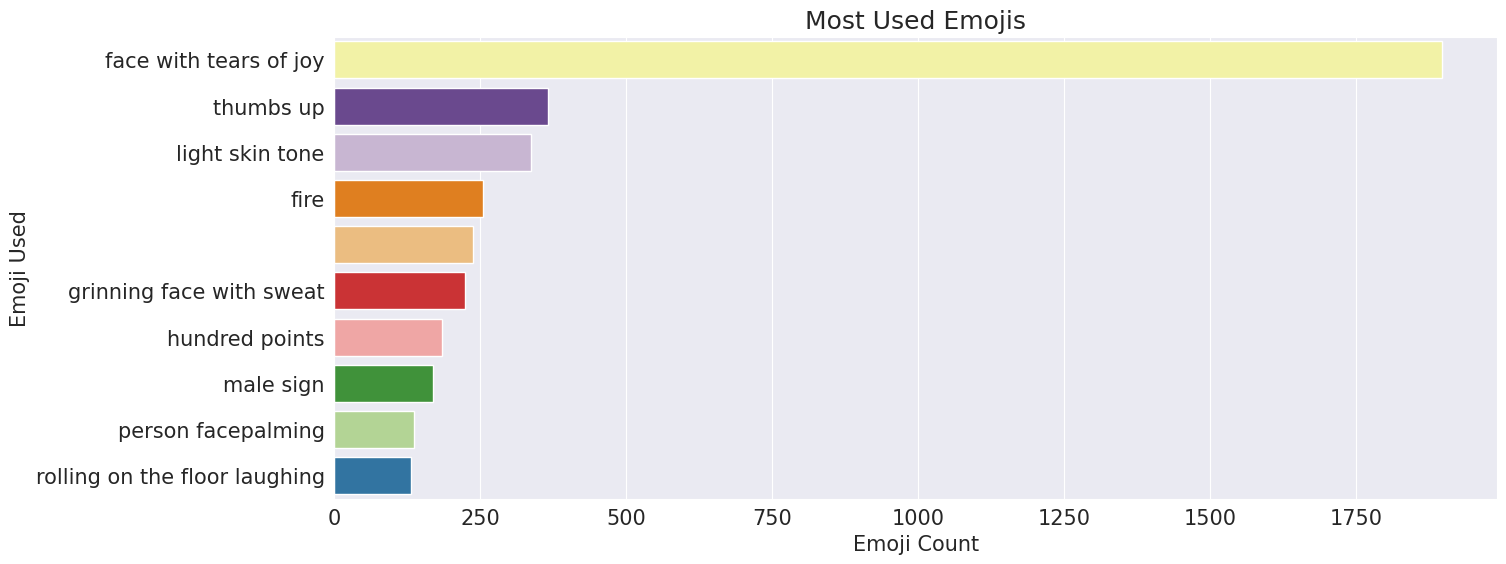

In [34]:
# Plotting the top 10 most used emojis
top_n = 10
top_emojis = emoji_df.head(top_n)

# Increasing the figure size
plt.figure(figsize=(15, 6))

# Better readability
import matplotlib
matplotlib.rcParams['font.size'] = 15

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;
sns.barplot(x=top_emojis['emoji_count'], y=top_emojis['emoji_description'], palette="Paired_r")

plt.title('Most Used Emojis')
plt.xlabel('Emoji Count')
plt.ylabel('Emoji Used')

# Saving the plot
plt.savefig('top10emoji.svg', format='svg')

# Display the plot
plt.show()

***Not that it is worth anything, but "😂" beats everyone by a huge margin!***

# **6. Most active days, most active hours, most active months.**


***Pre-processing***




In [35]:
# Additional Analysis: Grouping by Hour
if 'date_time' in df.columns:
    df3 = df.copy()
    df3['message_count'] = 1  # Helper column to keep a count
    df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

    # Group by hour and sum the counts
    grouped_by_time = df3.groupby('hour').sum().reset_index()

In [36]:
print(df.columns)

Index(['message', 'emojis'], dtype='object')


***Which hour of the day are most messages exchanged ?***

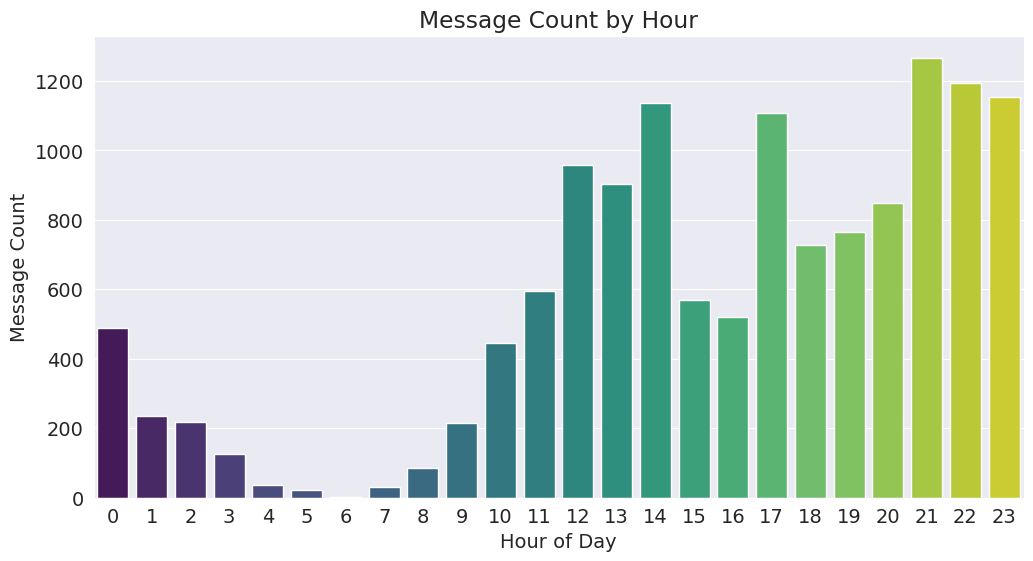

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to convert raw WhatsApp data to DataFrame
def rawToDf(file):
    '''Converts raw .txt file into a DataFrame'''

    split_formats = {
        '12hr': r'\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr': r'\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom': ''
    }
    datetime_formats = {
        '12hr': '%d/%m/%Y, %I:%M %p - ',
        '24hr': '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }

    with open(file, 'r', encoding='utf-8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n'))  # Combine lines into a single string
        user_msg = re.split(split_formats['12hr'], raw_string)[1:]  # Split by date-time pattern
        date_time = re.findall(split_formats['12hr'], raw_string)  # Find all date-time patterns

        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg})  # Create DataFrame

    # Convert date-time string to datetime type
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats['12hr'])

    # Extract user and message from user_msg column
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i)
        if len(a) > 1:
            usernames.append(a[1])
            msgs.append(a[2])
        else:
            usernames.append("group_notification")
            msgs.append(a[0])

    # Add user and message columns to DataFrame
    df['user'] = usernames
    df['message'] = msgs

    # Drop user_msg column
    df.drop('user_msg', axis=1, inplace=True)

    return df

# Path to WhatsApp chat data
file_path = '/content/whatsapp-chat-data.txt'

# Convert raw data to DataFrame using the function
df = rawToDf(file_path)

# Example analysis: Count messages by hour
df['hour'] = df['date_time'].dt.hour
grouped_by_hour = df.groupby('hour').size().reset_index(name='message_count')

# Set Seaborn style and figure size
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))

# Plot bar chart
sns.barplot(x='hour', y='message_count', data=grouped_by_hour, palette="viridis")
plt.title('Message Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Message Count')

# Save plot as SVG
plt.savefig('message_count_by_hour.svg', format='svg')

# Show plot
plt.show()

***Intrestingly, the group is most active around midnight, followed by afternoon.***

**Pre-processing weekdays and months**

***Now, we will be plotting grouped by day and respective group by month simultaneously, to see some interesting results.***

     Using plt.subplots to plot multiple charts in a grid.

In [74]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]

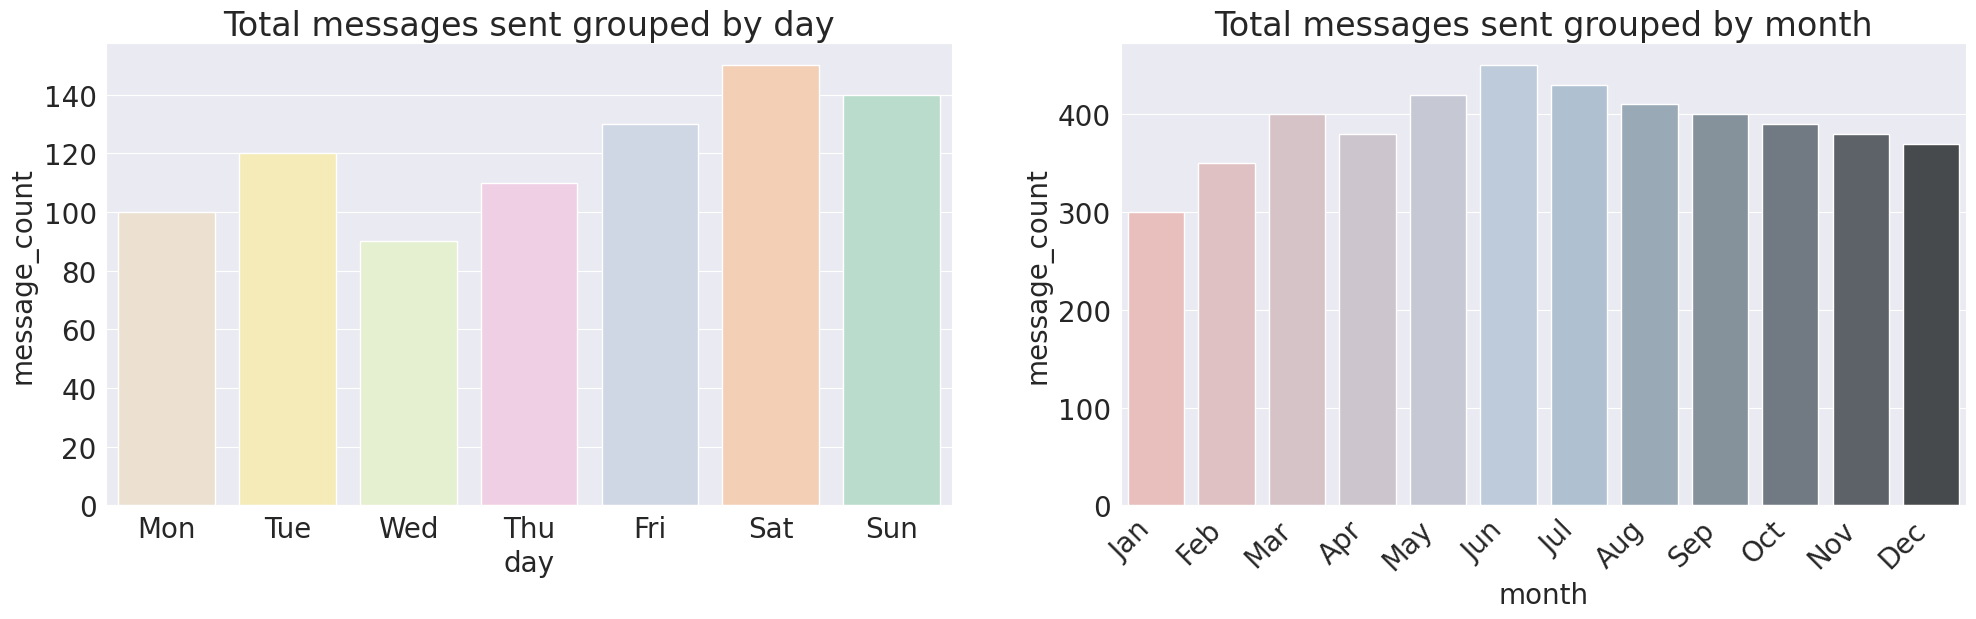

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df contains your WhatsApp chat data with 'day' and 'month' columns already extracted

# Sample data preparation (replace this with your actual data loading and preprocessing steps)
data = {
    'day': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    'message_count': [100, 120, 90, 110, 130, 150, 140]
}
grouped_by_day = pd.DataFrame(data)

data = {
    'month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'message_count': [300, 350, 400, 380, 420, 450, 430, 410, 400, 390, 380, 370]
}
grouped_by_month = pd.DataFrame(data)

# Set up the plot
fig, axs = plt.subplots(1, 2, figsize=(24, 6))
sns.set_style("darkgrid")

# PLOT 1: Messages grouped by weekday
sns.barplot(x='day', y='message_count', data=grouped_by_day, order=days, ax=axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(x='month', y='message_count', data=grouped_by_month, order=months, ax=axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month')

# Customize x-axis labels for months
plt.setp(axs[1].get_xticklabels(), rotation=45, ha='right')

# Saving the plots
plt.savefig('days_and_month.svg', format='svg')

# Show the plots
plt.show()

The group is most active on Saturday, and least active on wednesday.

In [97]:
import pandas as pd
import numpy as np

# Example data preparation
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Generate example data
np.random.seed(0)
data = {
    'month': np.random.choice(months, 100),
    'day': np.random.choice(days, 100),
    'message_count': np.random.randint(1, 50, 100)
}
df3 = pd.DataFrame(data)

# Grouping and pivot table creation
grouped_by_month_and_day = df3.groupby(['month', 'day']).sum().reset_index()[['month', 'day', 'message_count']]

# Creating a pivot table
pt = grouped_by_month_and_day.pivot_table(index='month', columns='day', values='message_count').reindex(index=months, columns=days)

# Displaying the DataFrame and pivot table for verification
print("DataFrame df3:")
print(df3.head())
print("\nPivot Table pt:")
print(pt.head())

DataFrame df3:
      month       day  message_count
0      June   Tuesday             17
1   January  Saturday             25
2     April   Tuesday             30
3  December  Thursday             22
4     April    Monday             47

Pivot Table pt:
day       Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
month                                                                   
January     49.0     32.0       56.0     115.0     NaN      25.0     NaN
February    65.0      NaN       42.0       6.0     NaN       NaN    42.0
March       49.0      NaN       89.0       NaN     NaN       NaN     4.0
April      108.0     30.0       47.0      40.0    45.0       NaN    99.0
May         73.0      NaN        NaN     105.0   111.0      34.0    27.0


## ***Now, we will plot a heatmap, combining the above to bar plots, for a better understanding!***


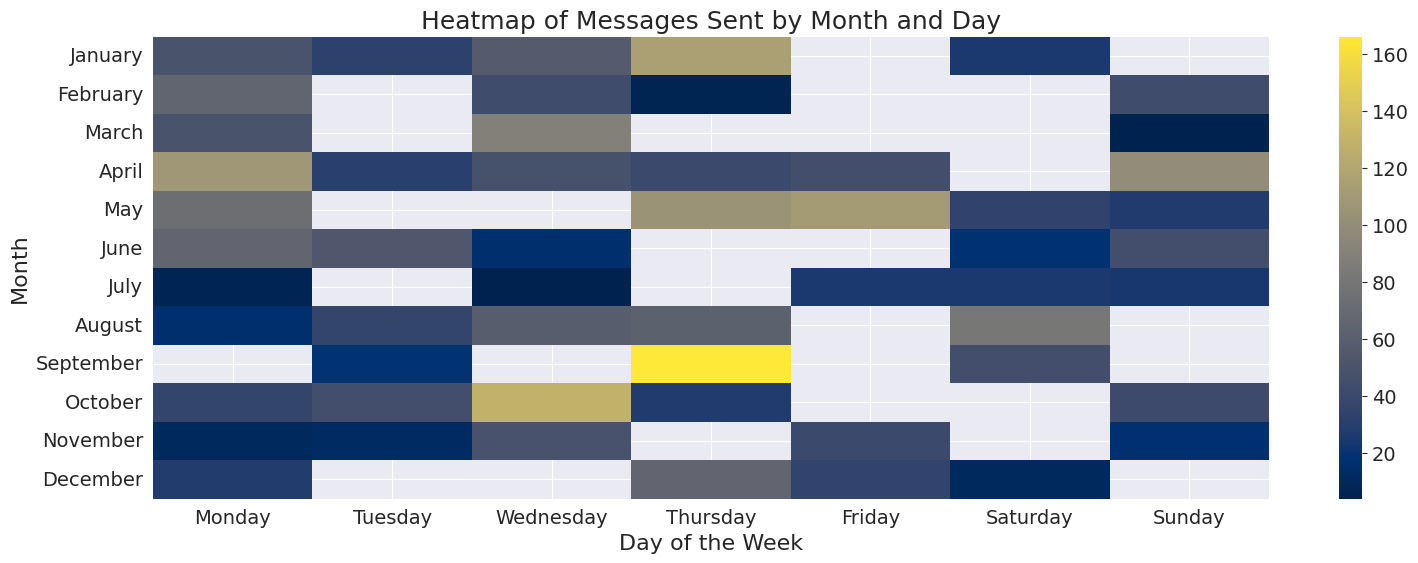

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the figure size and font size
plt.figure(figsize=(18, 6))
plt.rcParams['font.size'] = 14

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting the heatmap
sns.heatmap(pt, cmap='cividis')
plt.title('Heatmap of Messages Sent by Month and Day', fontsize=18)
plt.xlabel('Day of the Week', fontsize=16)
plt.ylabel('Month', fontsize=16)

# Saving the plot
plt.savefig('month_day_heatmap.png', dpi=300)

# Show the plot (optional)
plt.show()

# ***Inferences***



*   The group is more active on weekends, throughout the months.

*   September has the most lighter blue shades and more yellow gradients.

*   This gives a combined analysis, which is really helpful in real-time projects.



## ***Finally, I will be ending with the most used words, using WordCloud module in Python.***


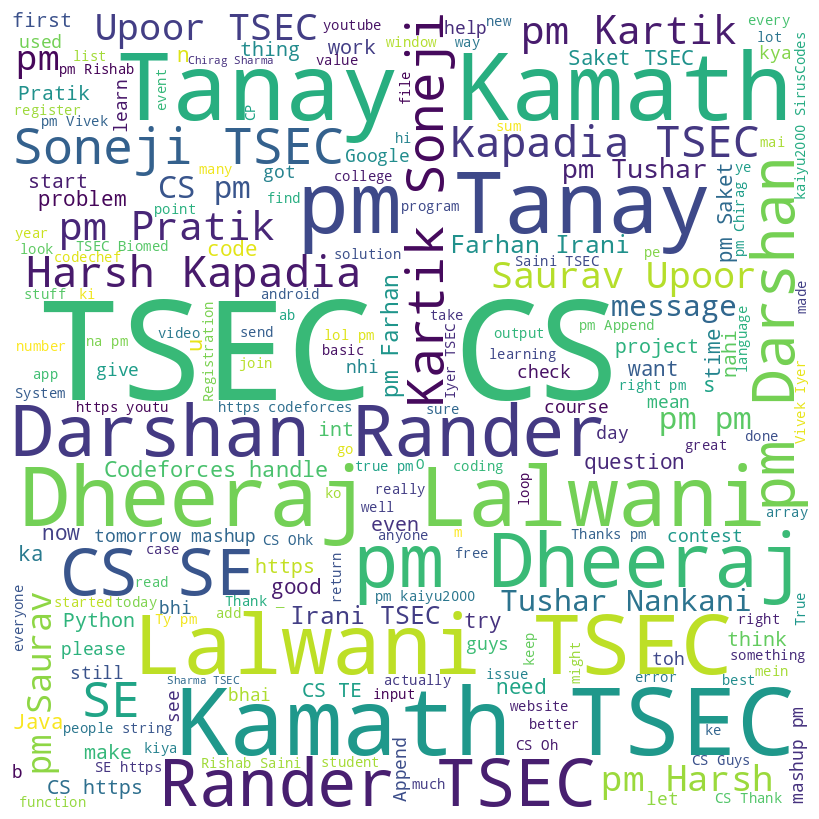

In [104]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Load WhatsApp chat data from file
file_path = '/content/whatsapp-chat-data.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    chat_data = file.readlines()

# Assuming chat_data is a list where each element is a message string
# Example preprocessing (replace with your actual preprocessing steps)
messages = []
for line in chat_data:
    # Example: Assuming each line contains a message, strip newline characters
    message = line.strip()
    if message:  # Ensure the line is not empty
        messages.append(message)

# Join all messages into a single string
all_messages = ' '.join(messages)

# Define stopwords and update them correctly
stopwords = set(STOPWORDS)
stopwords.update(['group', 'link', 'invite', 'joined', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])

# Generate WordCloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(all_messages)

# Plotting the WordCloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# Save the plot as a PNG file
plt.savefig('/content/wordcloud.png', dpi=300)

# Display the plot
plt.show()

# ***Conclusion***

*   The insights were really interesting to look at!

*   We first loaded the data as a .txt file coverted it using RawtoDF function.

*   Then we added helper columns, manipulated datetime entries.

*  Then, we started analysing our whatsapp data!

Here is what we looked at!



1.   **Overall frequency of total messages on the group.**

2.   **Top 10 most active days.**

3.   **Top 10 active users on the group (with a twist - Most active user had the least average message length ).**



    *   Ghosts present in the group. (shocking results - 80+ participants who haven't even sent a single message!)

4.  **Top 10 users most sent media.**


*   **TK beats everyone by a mile!**

5.  **Top 10 most used emojis.**


    *   using the emoji module!

6.  **Most active hours and weekdays.**

   *   Heatmaps of weekdays and months.

   *   Most active hours, weekdays, and months.

7.   **Most used words - WordCloud**









